## https://courseworks2.columbia.edu/courses/190553/files/19587975?wrap=1
## Trading strategy of a stock index based on the frequency of news releases for listed companies

In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
from datetime import datetime
import matplotlib.pyplot as plt
import random
random.seed(6666)

from tqdm import tqdm
import concurrent.futures

In [2]:
def load_financial_data(ticker:str, start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading {ticker} data')
    except FileNotFoundError:
        print(f'File not found...downloading the {ticker} data')
        df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
        df.to_pickle(output_file)
    return df

In [3]:
spy_data=load_financial_data('SPY', start_date=datetime(2000,1,1), end_date = datetime(2024,1,1), output_file='spy_data.pkl')
spy_data.to_csv('spy.csv')
spy_data.head()

File data found...reading SPY data


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.591133,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,89.931145,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.092049,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.644104,6227200
2000-01-07,140.31250,145.75000,140.062500,145.7500,93.792259,8066500


## News Data

In [4]:
import feedparser
from urllib.parse import quote

In [5]:
def encode_string_to_url(input_string):
    encoded_string = quote(input_string)
    return encoded_string

def construct_rss_url(after='2020-06-01', before='2020-06-02', search_terms = ['S&P500', 'SPY TICKER', 'S&P']):
    search_term = '%20OR%20'.join([encode_string_to_url(st) for st in search_terms])
    endpoint = f'https://news.google.com/rss/search?q={search_term}+after:{after}+before:{before}&ceid=US:en&hl=en-US&gl=US'
    return endpoint

def parse_rss_feed(url):
    # Parse the RSS feed
    feed = feedparser.parse(url)

    # Check if the feed parsing was successful
    if feed.bozo == 0:
        return len(feed.entries)
    else:
        # print("Error parsing the RSS feed.")
        raise Exception('Failed feed pull')

In [6]:
news_articles_df = pd.DataFrame(index=spy_data.index, columns=['article_count'])

In [7]:
def load_news_data(output_file):
    try:
        df = pd.read_pickle(output_file)
        print(f'File data found...reading news data')
    except FileNotFoundError:
        # Function to process each date
        def process_date(date):
            after = date.strftime('%Y-%m-%d')
            before = (date + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
            return parse_rss_feed(construct_rss_url(after, before))
        
        # Create ThreadPoolExecutor with maximum workers equal to the number of available CPUs
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Process each date in parallel
            results = list(tqdm(executor.map(process_date, spy_data.index), total=len(spy_data.index)))
        
        # Combine results into a DataFrame
        for i, date in enumerate(spy_data.index):
            news_articles_df.at[date, 'article_count'] = results[i]
        
        # Save the DataFrame to pickle file
        news_articles_df.to_pickle(output_file)
        
        df = news_articles_df  # Assigning df to the DataFrame after loading the news data
        
    return df

# Load news data in parallel
news_articles_df = load_news_data('news_articles.pkl')

# Save the DataFrame to CSV
news_articles_df.to_csv('news_articles.csv')


File data found...reading news data


In [8]:
((news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0).sum()

1447.0

## Backtest

In [9]:
def backtest(orders, initial_capital = 10000):
    portfolio = pd.DataFrame(index=spy_data.index)
    portfolio['orders'] = orders

    portfolio['cash'] = 0
    portfolio['holding'] = 0
    portfolio['total'] = 0
    portfolio.at[portfolio.index[0], 'cash'] = initial_capital

    for i in range(1, len(portfolio)):
        if portfolio.at[portfolio.index[i], 'orders'] == 1:
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'cash'] = 0
        elif portfolio.at[portfolio.index[i], 'orders'] == -1:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'holding'] * spy_data['Close'][i]
            portfolio.at[portfolio.index[i], 'holding'] = 0
        else:
            portfolio.at[portfolio.index[i], 'cash'] = portfolio.at[portfolio.index[i-1], 'cash']
            portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'holding']

    portfolio['total'] = portfolio['cash'] + portfolio['holding'] * spy_data['Close']

    return portfolio

In [10]:
def portfolio_signals(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(spy_data.index, spy_data['Close'], label='SPX Close Price')
        ax.plot(portfolio[portfolio['orders'] == 1].index, spy_data['Close'][portfolio['orders'] == 1], '^', markersize=5, color='g', label='Buy Signal')
        ax.plot(portfolio[portfolio['orders'] == -1].index, spy_data['Close'][portfolio['orders'] == -1], 'v', markersize=5, color='r', label='Sell Signal')
        ax.set_title(f'Portfolio {i} Buy and Sell Signals')
        ax.legend()

    plt.tight_layout()
    plt.show()

In [11]:
# import matplotlib.pyplot as plt

def portfolio_val_over_time(portfolios):
    num_portfolios = len(portfolios)
    fig, axs = plt.subplots(num_portfolios, 1, figsize=(14, 7*num_portfolios))

    for i, (portfolio, ax) in enumerate(zip(portfolios, axs)):
        ax.plot(portfolio.index, portfolio['total'], label='Total Value')
        ax.plot(portfolio.index, portfolio['cash'], label='Cash')
        ax.plot(portfolio.index, portfolio['holding'], label='Holding Value')
        ax.set_title(f'Portfolio {i} Value Over Time')
        ax.legend()

    plt.tight_layout()
    plt.show()


C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '72.59528130671507' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

22875.29720445749


C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '70.9849157054126' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.at[portfolio.index[i], 'holding'] = portfolio.at[portfolio.index[i-1], 'cash'] / spy_data['Close'][i]
C:\Users\chaud\AppData\Local\Temp\ipykernel_36268\442257449.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer 

23383.504180974203


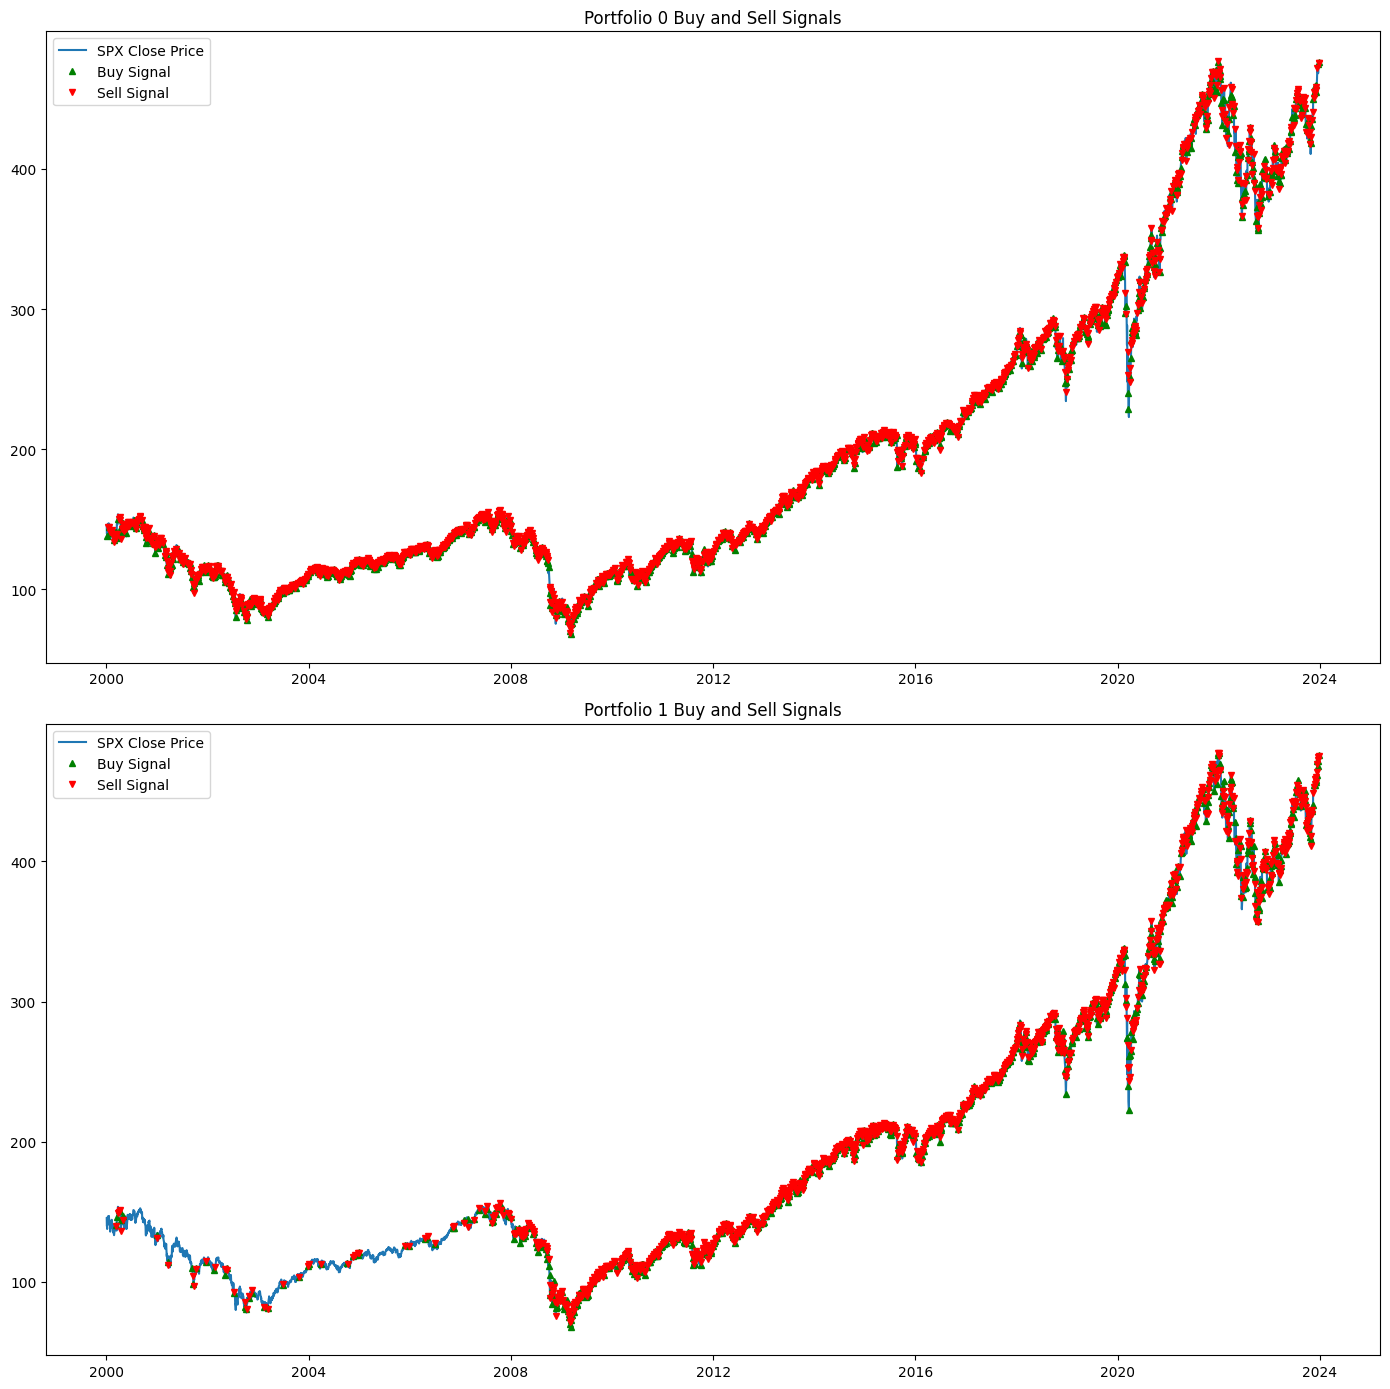

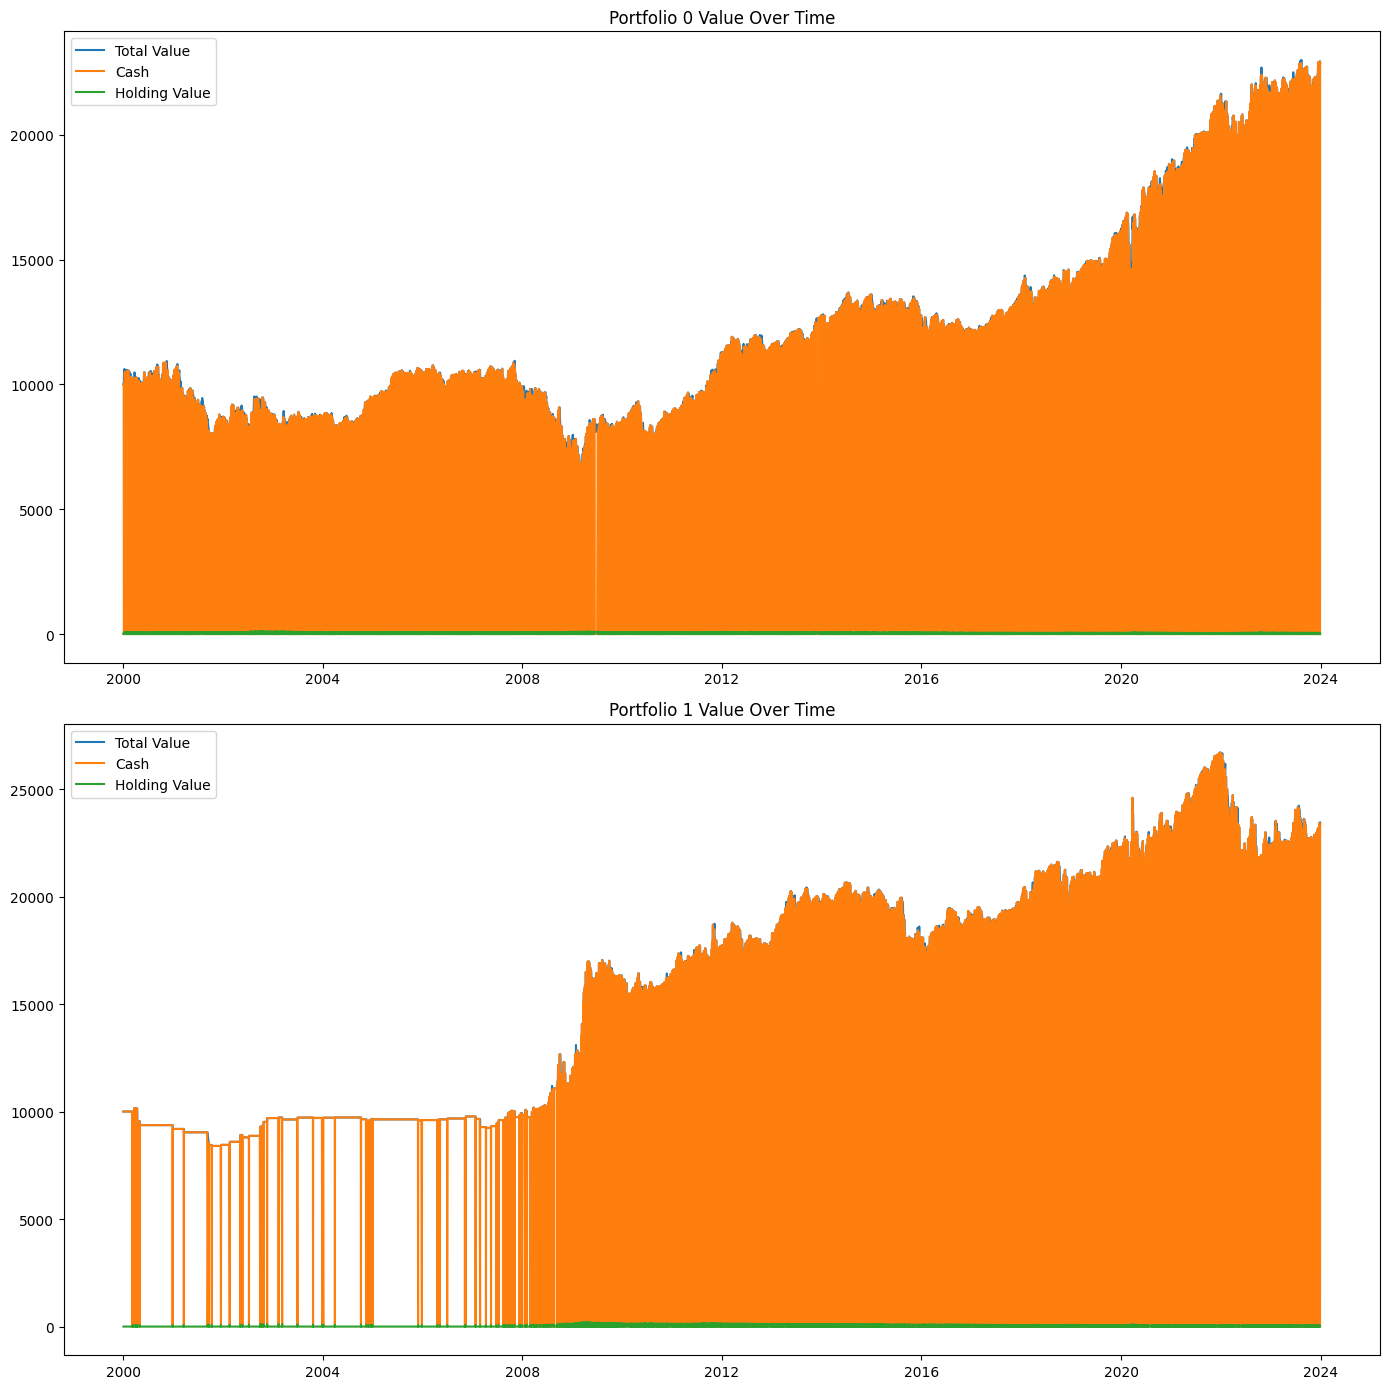

In [12]:
signals = pd.DataFrame(index=spy_data.index)
signals['signal'] = [random.randint(0, 1) for _ in range(len(signals))]
signals['orders'] = signals['signal'].diff()

portfolio_1 = backtest(signals['orders'])
print(portfolio_1.at[portfolio_1.index[-1], 'total'])


signals['signal'] = (news_articles_df['article_count'].shift() - news_articles_df['article_count'] < 0) * 1.0
signals['orders'] = signals['signal'].diff()
portfolio_2 = backtest(signals['orders'])
print(portfolio_2.at[portfolio_2.index[-1], 'total'])

portfolio_signals([portfolio_1, portfolio_2])
portfolio_val_over_time([portfolio_1, portfolio_2])
